Most of the functions in this code has been taken from [this article](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398) by Raymond Yuan.

In [0]:
import os
img_dir = "/tmp/nst"

if not os.path.exists(img_dir):
  os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b2/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/c/c1/Lionel_Messi_20180626.jpg

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (10,10)
mpl.rcParams["axes.grid"] = False

import numpy as np
from PIL import Image
import time
import functools


In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [4]:
tf.enable_eager_execution()
print("Eager Execution {}".format(tf.executing_eagerly()))

Eager Execution True


In [0]:
style_path = "/tmp/nst/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg"
content_path = "/tmp/nst/Lionel_Messi_20180626.jpg"

### Visualize The Input

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)
  return img
  

In [0]:
def im_show(img, title=None):
  out = np.squeeze(img, axis=0)
  
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


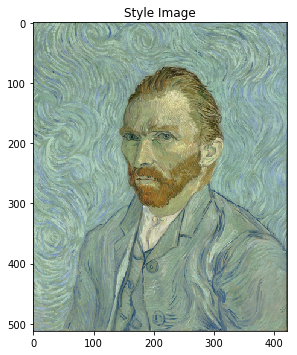

In [8]:
plt.figure(figsize=(10,10))

content = load_img(content_path)
style = load_img(style_path)

plt.subplot(1, 2, 1)
im_show(content, "Content Image")

plt.subplot(1, 2, 1)
im_show(style, "Style Image")
plt.show()


In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if(len(x.shape)==4):
    x = np.squeeze(x, 0)
  assert len(x.shape)==3, ("Input to deprocess an image must of dimesion"
                          "[1, height, width, channel] or [height, width, channel]")
  if len(x.shape)!=3:
    raise ValueError("Invalid Input to deprocessing image")
  
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  
  x= x[:, :, ::-1]
  
  x=np.clip(x, 0, 255).astype('uint8')
  return x


In [0]:
content_layers = ['block5_conv2']

style_layers = ["block1_conv1", 
               "block2_conv1", 
               "block3_conv1", 
               "block4_conv1",
               "block5_conv1"
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  
  return models.Model(vgg.input, model_outputs)


In [0]:
def content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))
  

In [0]:
def gram_matrix(input_tensor):
  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

  

In [0]:
def get_features_representations(model, content_path, style_path):
  
  content_img = load_and_process_img(content_path)
  style_img = load_and_process_img(style_path)
  
  style_outputs = model(style_img)
  content_outputs = model(content_img)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features


In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0
  
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer*get_style_loss(comb_style[0], target_style)
  
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer*content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight
  
  loss = style_score + content_score
  return loss, style_score, content_score
  
  

In [0]:
def compute_gradients(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_path,
                      style_path,
                      num_iterations=1000,
                      content_weight=1e3,
                      style_weight=1e-2):
  model = get_model()
  
  for layer in model.layers:
    layer.trainable = False
  
  
  style_features, content_features = get_features_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  
  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, content_weight)
  cfg={
      'model':model,
      'loss_weights':loss_weights,
      'init_image':init_image,
      'gram_style_features':gram_style_features,
      'content_features':content_features
  }
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means
  
  imgs=[]
  for i in range(num_iterations):
    grads, all_loss = compute_gradients(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()
    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())
    if i%display_interval == 0:
      start_time = time.time()
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

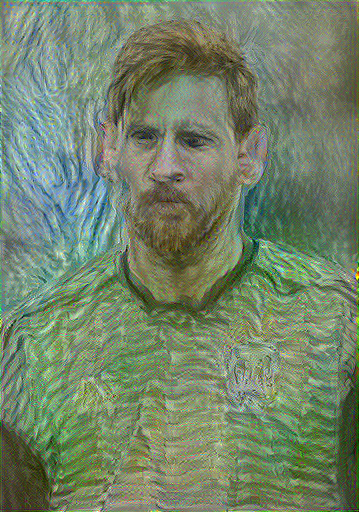

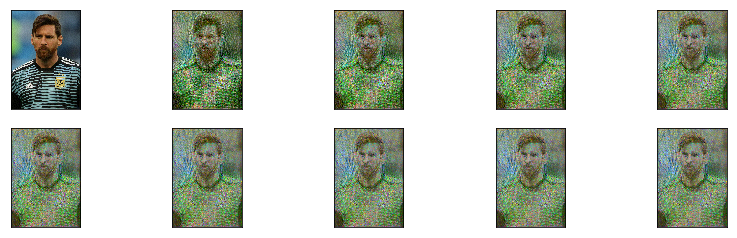

In [19]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)
Image.fromarray(best)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  
  plt.subplot(1, 2, 1)
  im_show(content, 'Content Image')

  plt.subplot(1, 2, 2)
  im_show(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

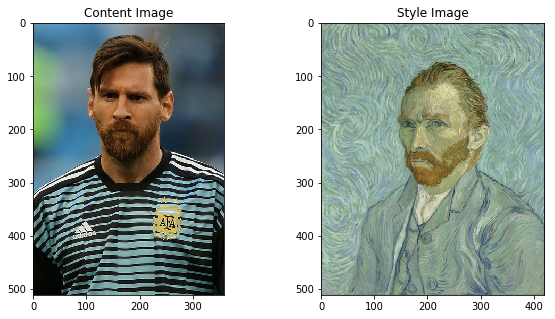

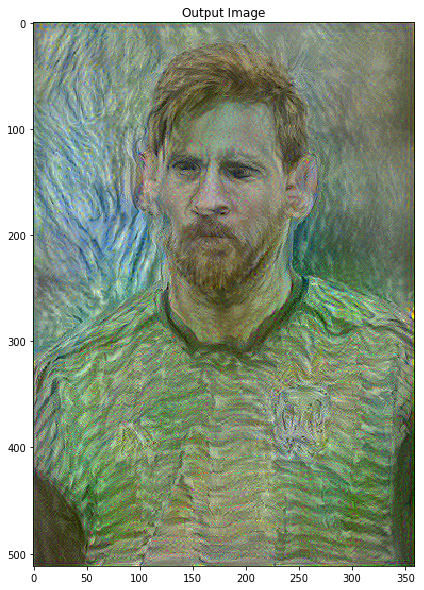

In [21]:
show_results(best, content_path, style_path)